In [2]:
# the input file has already been downloaded

with open("input.txt") as f:
    data = f.read()

# create the vocab
chars = sorted(list(set(data)))
print(''.join(chars))

atoi = {c: i for i, c in enumerate(chars)}
itoa = {i: c for i, c in enumerate(chars)}

encode = lambda str: [atoi[c] for c in str]
decode = lambda arr: ''.join([itoa[i] for i in arr])

arr = encode("hello")
print(arr)
print(decode(arr))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
[46, 43, 50, 50, 53]
hello


In [3]:
import torch
# convert data into a tensor
if not type(data) is torch.Tensor:
    data = torch.tensor(encode(data), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

# split the data into training and validation
# NOTE:~ we may be able to do better than this by picking random chunks
def split(data, frac=0.8):
    n = int(frac * len(data))
    return data[:n], data[n:]

train_data, val_data = split(data)

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [4]:
# we want to chunk the data, since it's sequential and we want the transformer
# to see different chunk sizes. chunk = context (context length)
block_size = 8
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    print(f"Input:  {x[:t+1]} Output: {y[t]}")


Input:  tensor([18]) Output: 47
Input:  tensor([18, 47]) Output: 56
Input:  tensor([18, 47, 56]) Output: 57
Input:  tensor([18, 47, 56, 57]) Output: 58
Input:  tensor([18, 47, 56, 57, 58]) Output: 1
Input:  tensor([18, 47, 56, 57, 58,  1]) Output: 15
Input:  tensor([18, 47, 56, 57, 58,  1, 15]) Output: 47
Input:  tensor([18, 47, 56, 57, 58,  1, 15, 47]) Output: 58


In [5]:
# now we want batches of chunked data
torch.manual_seed(1337)
batch_size = 4
block_size = 8

def get_batch(split):
    # generate a small batch of data by sampling chunks at random
    data = train_data if split == 'train' else val_data
    ix = torch.randint( len(data) - block_size, (batch_size,) )
    x = torch.stack(  [data[i:i+block_size] for i in ix] )
    y = torch.stack(  [data[i+1:i+block_size+1] for i in ix] )
    return x, y

xb, yb = get_batch('train')
print(xb.shape, yb.shape)
print("inputs\n", xb)
print("outputs\n", yb)

print("------")

for b in range(batch_size):
    # now we are in a batch, pick that chunk
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"Input: {context.tolist()} Output: {target}")


torch.Size([4, 8]) torch.Size([4, 8])
inputs
 tensor([[58, 63,  8,  0,  0, 19, 24, 27],
        [39, 59, 45, 46, 58,  1, 46, 43],
        [49, 43, 57,  1, 53, 50, 42,  1],
        [52, 41, 47, 43, 52, 58,  1, 56]])
outputs
 tensor([[63,  8,  0,  0, 19, 24, 27, 33],
        [59, 45, 46, 58,  1, 46, 43,  1],
        [43, 57,  1, 53, 50, 42,  1, 46],
        [41, 47, 43, 52, 58,  1, 56, 47]])
------
Input: [58] Output: 63
Input: [58, 63] Output: 8
Input: [58, 63, 8] Output: 0
Input: [58, 63, 8, 0] Output: 0
Input: [58, 63, 8, 0, 0] Output: 19
Input: [58, 63, 8, 0, 0, 19] Output: 24
Input: [58, 63, 8, 0, 0, 19, 24] Output: 27
Input: [58, 63, 8, 0, 0, 19, 24, 27] Output: 33
Input: [39] Output: 59
Input: [39, 59] Output: 45
Input: [39, 59, 45] Output: 46
Input: [39, 59, 45, 46] Output: 58
Input: [39, 59, 45, 46, 58] Output: 1
Input: [39, 59, 45, 46, 58, 1] Output: 46
Input: [39, 59, 45, 46, 58, 1, 46] Output: 43
Input: [39, 59, 45, 46, 58, 1, 46, 43] Output: 1
Input: [49] Output: 43
Input: [

In [6]:
# try the bigram model

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)

class BigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are bot (B, T) where B is batch size and T is time aka context length
        # C = channels = vocab size
        logits = self.token_embedding_table(idx) # (B, T, C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape  
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # predict
            logits, loss = self(idx)
            # just take the last time step
            logits = logits[:, -1, :] # (B, C)
            # convert the logits to probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append to the sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    
vocab_size = len(chars)
m = BigramModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape, loss)

def print_generated_sequence(model, max_new_tokens):
    idx = torch.zeros((1, 1), dtype=torch.long) # newline char in our vocab
    idx = m.generate(idx, max_new_tokens) # generate new tokens
    idx = idx[0].tolist() # convert to a list
    print(decode(idx))

print_generated_sequence(m, 100)

torch.Size([32, 65]) tensor(5.0493, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


Epoch 1000 Loss 3.681859254837036
Epoch 2000 Loss 3.282238006591797
Epoch 3000 Loss 2.791837692260742
Epoch 4000 Loss 2.592615842819214
Epoch 5000 Loss 2.5700435638427734
Epoch 6000 Loss 2.521210193634033
Epoch 7000 Loss 2.5207767486572266
Epoch 8000 Loss 2.409142255783081
Epoch 9000 Loss 2.491442918777466
Epoch 10000 Loss 2.5331475734710693


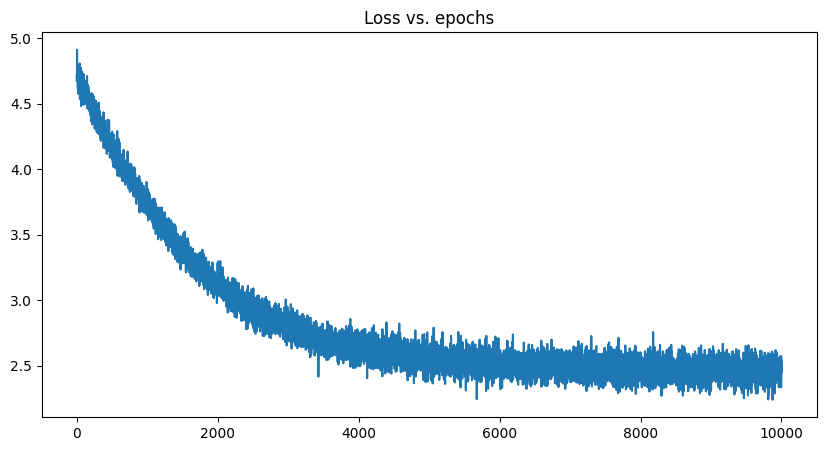

In [7]:
import matplotlib.pyplot as plt
# plot the loss
def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Loss vs. epochs')
    plt.show()

# create an optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
batch_size = 32
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1} Loss {loss.item()}")

plot_loss(losses)

In [8]:
print_generated_sequence(m, 500)


lso br. ave aviu:


Smy, may be ivee iuedrd whar ksth y h bora s be hese, woweee; the! KI 'de, ulseecherd d o blllando;LUCEO, oraingofof wan!
RIfans picspeserer hee tha,
TOFonk? me ain ckntoty dedo bo'llll st ta d:
ELIS me hurf lal y, ma dus pe athouo
By bre ndy; by s afreanoo adicererupa anse tecorro llaus a!
OLengerithesththenou theal amas trr
TI ar I t, mes, o IUSt my w,

Whank'the
THek' merer, dd
We ntem lud engitonso; cer ize helour
Jginte the?
Thak orblyor id oree chot, p,
Bealivolde Th ll


Let's figure out how to create the attention head

In [9]:
torch.manual_seed(42) 
a = torch.ones((3, 3), dtype=torch.float32)

# fill a (3,2) torch tensor with random longs
b = torch.randint(0, 10, (3, 2), dtype=torch.float32)

c = a @ b

print("a:")
print(a)
print("b:")
print(b)
print("c:")
print(c)

a:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
b:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c:
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


In [10]:
# now we want to create a tensor in a triangle shape with lower part being 1s
a = torch.tril(torch.ones((3, 3)))
print("a:")
print(a)

c = a @ b

print("b:")
print(b)
print("c:")
print(c)

a:
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
b:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c:
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


In [11]:
# now let's get an average
a = a / torch.sum(a, dim=1, keepdim=True)
print(a)

c = a @ b

print("b:")
print(b)
print("c:")
print(c)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c:
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [24]:
# assumptions for simplicity
B = 4 # batch size
T = 8 # context length
C = 2 # vocab size

torch.manual_seed(1337)
x = torch.randn(B, T, C)
print(f"x: {x.shape}")

# for means along columns
xb = torch.zeros(B, T, C)
for b in range(B):
    for t in range(T):
        x_prev  = x[b, :t+1] # t, C
        xb[b, t] = torch.mean(x_prev, dim=0)
print(f"xb: {xb.shape}")

wei = torch.tril(torch.ones((T, T)))
wei = wei / torch.sum(wei, dim=1, keepdim=True)
print("wei:")
print(wei)

xb2 = wei @ x # (T, T) * (B, T, C) -> (B, T, T) * (B, T, C) -> (B, T, C)
print(f"xb: {xb.shape}")

print(torch.allclose(xb, xb2))

x: torch.Size([4, 8, 2])
xb: torch.Size([4, 8, 2])
wei:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
xb: torch.Size([4, 8, 2])
True


In [28]:
tril = torch.tril(torch.ones(T, T))
print(tril)
wei = torch.zeros((T, T))
print(wei)
wei = wei.masked_fill(tril == 0, float('-inf'))
print(wei)
wei = torch.softmax(wei, dim=1)
print(wei)
xb3 = wei @ x
print(torch.allclose(xb, xb3))

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0.,

In [30]:
# self attention block
torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

# self-attention head
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)
q = query(x)
wei = q @ k.transpose(-2, -1) # (B, T, h) dot (B, h, T) -> (B, T, T)


til = torch.tril((torch.ones(T, T)))
# wei = torch.zeros((T, T)) no longer zeros, but from q and k
wei = wei.masked_fill(til == 0, float('-inf'))
print(f"wei: {wei.shape} x.shape: {x.shape}")
wei = F.softmax(wei, dim=-1)
print(wei)

v = value(x)
print(f"v: {v.shape}")
out = wei @ v
print(out.shape)


wei: torch.Size([4, 8, 8]) x.shape: torch.Size([4, 8, 32])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.774

Very strange comment on the above...

So the `wei = wei.masked_fill(til == 0, float('-inf'))` line makes this a "decoder" block of self-attention, because tokens are NOT aware of future tokens, only previous ones.

If we delete this line, then ie becomes an "encoder" block, because all tokens ARE aware of all other tokens.

I guess: 
- in "decoder" blocks, tokens are trying to decode the past to predict the future
- in "encoder" blocks tokens are trying to encode all the information in the block


./plot_002.png


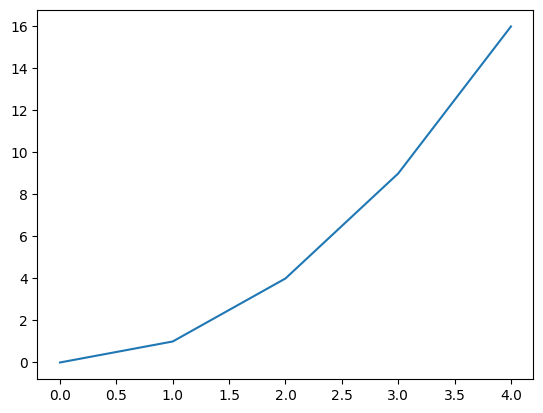

In [38]:
import os
import re

def generate_next_filename(basename, ext, num_digits=3, directory="."):
    # Compile a regex pattern to match files with the given basename, digits, and extension
    pattern = re.compile(rf"^{re.escape(basename)}_(\d{{{num_digits}}}){re.escape(ext)}$")
    
    # List all files in the directory
    files = os.listdir(directory)
    
    # Find all matching files and extract their counters
    counters = []
    for file in files:
        match = pattern.match(file)
        if match:
            counters.append(int(match.group(1)))
    
    # Determine the next counter value
    next_counter = max(counters, default=0) + 1
    
    # Generate the next filename
    next_filename = f"{basename}_{str(next_counter).zfill(num_digits)}{ext}"
    return os.path.join(directory, next_filename)

def test_plot():
    # Create a plot
    plt.figure()
    plt.plot([0, 1, 2, 3, 4], [0, 1, 4, 9, 16])

    # Generate a filename for the plot
    filename = generate_next_filename("plot", ".png", directory=".")
    plt.savefig(filename)
    print(filename)

test_plot()